<a href="https://colab.research.google.com/github/maximum4645/Garbage_Classification/blob/main/exp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import adjust_sharpness
import matplotlib.pyplot as plt
import numpy as np

# Data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download and extract the dataset
dataset_zip = 'garbage-classification.zip'
base_dir = './Garbage_Classification'
data_dir = os.path.join(base_dir, 'Garbage classification/Garbage classification')

if not os.path.exists(data_dir):
    print("Downloading Garbage Classification dataset...")
    !kaggle datasets download -d asdasdasasdas/garbage-classification -p .
    print("Extracting dataset...")
    !unzip -q garbage-classification.zip -d {base_dir}
    os.remove(dataset_zip)
    print("Download and extraction complete!")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 79% 65.0M/82.0M [00:01<00:00, 52.8MB/s]
100% 82.0M/82.0M [00:01<00:00, 44.2MB/s]
Extracting dataset...
Download and extraction complete!


In [4]:
# Define transformations for normalization and data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=data_dir)

# Split into training and testing datasets
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Apply transformations
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Print class names and dataset sizes
classes = dataset.classes
print("Classes:", classes)
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train dataset size: 2021
Test dataset size: 506


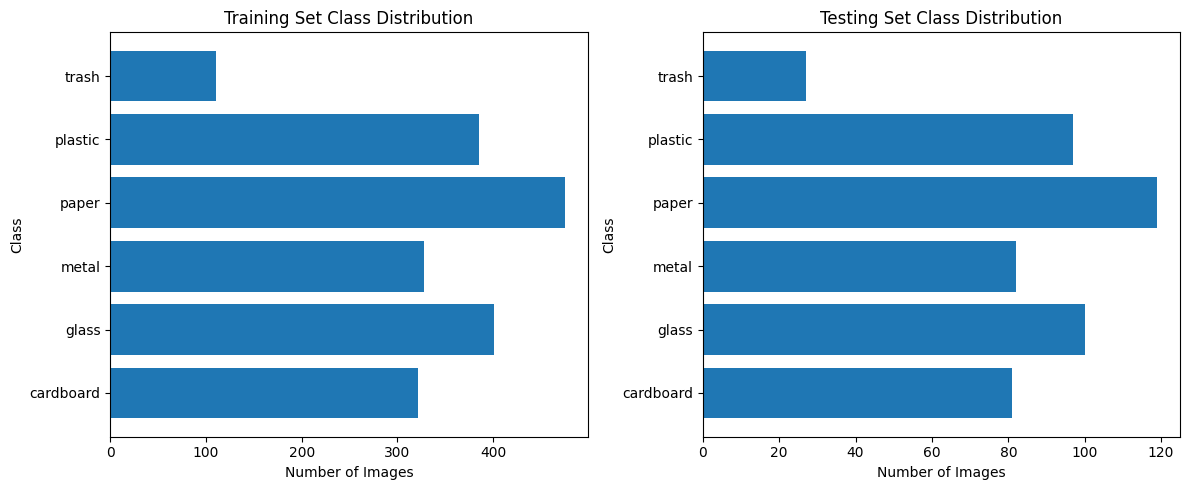

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


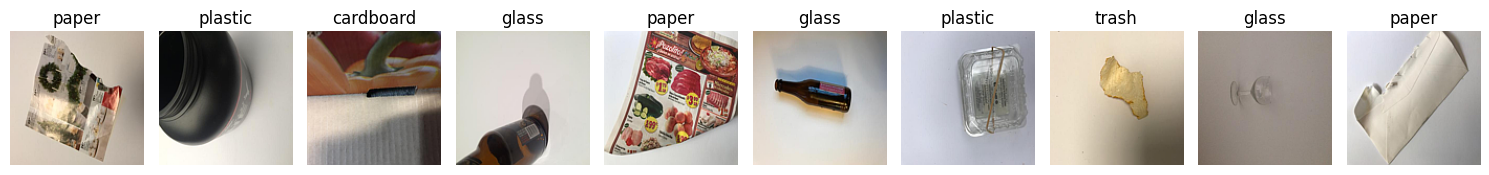

In [6]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], classes)


# Model

In [7]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0
from torchvision.models import ResNet18_Weights, MobileNet_V2_Weights, EfficientNet_B0_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 6

# # Define ResNet-18
# resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
# for param in resnet18_model.parameters():
#     param.requires_grad = False  # Freeze all layers
# # Unfreeze the last two residual blocks (layer3 and layer4)
# for param in resnet18_model.layer3.parameters():
#     param.requires_grad = True
# for param in resnet18_model.layer4.parameters():
#     param.requires_grad = True
# # Modify the fully connected (FC) layer for 6 classes
# resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
# resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
# resnet18_model = resnet18_model.to(device)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 6 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# # Define EfficientNet_B0
# efficientnet_b0_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# for param in efficientnet_b0_model.parameters():
#     param.requires_grad = False  # Freeze all layers
# # Unfreeze the last two convolutional blocks
# for param in efficientnet_b0_model.features[-2:].parameters():
#     param.requires_grad = True
# # Modify the classifier for 6 classes
# efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)
# efficientnet_b0_model.classifier[1].requires_grad = True
# efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(mobilenet_v2_model)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 74.4MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Before training


MobileNet_v2 Metrics:
Accuracy: 17.59%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.10      0.10      0.10        81
       glass       0.30      0.38      0.33       100
       metal       0.22      0.26      0.24        82
       paper       0.20      0.16      0.18       119
     plastic       0.04      0.01      0.02        97
       trash       0.02      0.07      0.04        27

    accuracy                           0.18       506
   macro avg       0.15      0.16      0.15       506
weighted avg       0.17      0.18      0.17       506



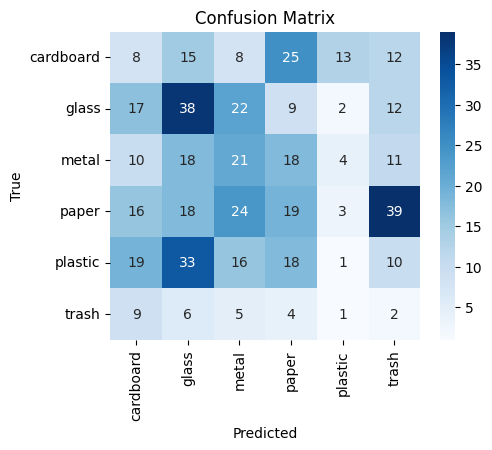

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# # Evaluate ResNet-18
# print("ResNet-18 Metrics:")
# resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# # Evaluate EfficientNet_B0
# print("\nEfficientNet_B0 Metrics:")
# efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


# Training

In [9]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [10]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF
import optuna

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class
class_counts = Counter([train_set.dataset.targets[i] for i in train_idx])
max_class_count = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {classes[class_idx]}: {count} -> {max_class_count}")

        # Get all images and their correct labels for this class
        class_images = [train_set.dataset[i] for i in train_idx if train_set.dataset.targets[i] == class_idx]

        # Apply augmentations
        for _ in range(diff):
            img, label = random.choice(class_images)  # Preserve correct label
            augmented_img = TF.rotate(img, angle=random.uniform(-15, 15))
            augmented_img = TF.hflip(augmented_img) if random.random() > 0.5 else augmented_img
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Combine original and augmented data for the training subset
train_dataset = [(train_set.dataset[i][0], train_set.dataset.targets[i]) for i in train_idx]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ********** OPTUNA INTEGRATED **********

# ================== Create DataLoaders (Dynamic) ==================
def get_data_loaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ================== Define Optuna Objective ==================
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Get DataLoaders with the suggested batch size
    train_loader, val_loader = get_data_loaders(batch_size)

    # Define the model
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze all layers in the features section
    # Unfreeze the last two inverted residual blocks
    for param in model.features[-12:].parameters():  # Adjusted for two blocks
        param.requires_grad = True
    # Modify the classifier for 6 classes
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model.classifier[1].requires_grad = True
    model = model.to(device)

    # Define optimizer and criterion
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5
    )

    # Return the best validation loss
    return min(val_losses)

# ================== Run Optuna Study ==================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# ================== Best Hyperparameters ==================
print("Best Hyperparameters:", study.best_params)

# # ================== Train ResNet-18 ==================
# print("Training ResNet-18...")
# resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
# resnet18_train_losses, resnet18_val_losses = train_model(
#     resnet18_model, train_loader, val_loader, criterion, resnet18_optimizer, device
# )

# # ================== Train MobileNet_v2 ==================
# print("\nTraining MobileNet_v2...")
# mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)
# mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
#     mobilenet_v2_model, train_loader, val_loader, criterion, mobilenet_v2_optimizer, device
# )

# # ================== Train EfficientNet_B0 ==================
# print("\nTraining EfficientNet_B0...")
# efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.001, momentum=0.9)
# efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
#     efficientnet_b0_model, train_loader, val_loader, criterion, efficientnet_b0_optimizer, device
# )


Augmenting class glass: 402 -> 472
Augmenting class metal: 321 -> 472
Augmenting class cardboard: 332 -> 472
Augmenting class plastic: 89 -> 472


[I 2024-12-17 09:07:13,753] A new study created in memory with name: no-name-068f07cd-784c-4ef1-b17e-6571d9011705
<ipython-input-10-eded31f6b088>:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
<ipython-input-10-eded31f6b088>:114: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)


Epoch 1/20, Train Loss: 1.5680, Val Loss: 1.4188
Epoch 2/20, Train Loss: 1.1371, Val Loss: 1.2102
Epoch 3/20, Train Loss: 0.8706, Val Loss: 1.0668
Epoch 4/20, Train Loss: 0.7016, Val Loss: 0.9759
Epoch 5/20, Train Loss: 0.5833, Val Loss: 0.9068
Epoch 6/20, Train Loss: 0.4783, Val Loss: 0.8532
Epoch 7/20, Train Loss: 0.4131, Val Loss: 0.8144
Epoch 8/20, Train Loss: 0.3640, Val Loss: 0.7840
Epoch 9/20, Train Loss: 0.3059, Val Loss: 0.7613
Epoch 10/20, Train Loss: 0.2734, Val Loss: 0.7413
Epoch 11/20, Train Loss: 0.2406, Val Loss: 0.7205
Epoch 12/20, Train Loss: 0.2089, Val Loss: 0.7100
Epoch 13/20, Train Loss: 0.1881, Val Loss: 0.6947
Epoch 14/20, Train Loss: 0.1572, Val Loss: 0.6919
Epoch 15/20, Train Loss: 0.1453, Val Loss: 0.6937
Epoch 16/20, Train Loss: 0.1298, Val Loss: 0.6834
Epoch 17/20, Train Loss: 0.1226, Val Loss: 0.6733
Epoch 18/20, Train Loss: 0.1009, Val Loss: 0.6720
Epoch 19/20, Train Loss: 0.0964, Val Loss: 0.6723


[I 2024-12-17 09:08:34,370] Trial 0 finished with value: 0.6719815954566002 and parameters: {'lr': 0.0063818188831173015, 'momentum': 0.5424424829365534, 'batch_size': 128}. Best is trial 0 with value: 0.6719815954566002.


Epoch 20/20, Train Loss: 0.0841, Val Loss: 0.6760
Epoch 1/20, Train Loss: 1.5275, Val Loss: 1.3654
Epoch 2/20, Train Loss: 1.0167, Val Loss: 1.1271
Epoch 3/20, Train Loss: 0.7377, Val Loss: 0.9993
Epoch 4/20, Train Loss: 0.5766, Val Loss: 0.9091
Epoch 5/20, Train Loss: 0.4576, Val Loss: 0.8427
Epoch 6/20, Train Loss: 0.3686, Val Loss: 0.8057
Epoch 7/20, Train Loss: 0.3066, Val Loss: 0.7713
Epoch 8/20, Train Loss: 0.2599, Val Loss: 0.7404
Epoch 9/20, Train Loss: 0.2130, Val Loss: 0.7232
Epoch 10/20, Train Loss: 0.1806, Val Loss: 0.7195
Epoch 11/20, Train Loss: 0.1576, Val Loss: 0.7080
Epoch 12/20, Train Loss: 0.1291, Val Loss: 0.7009
Epoch 13/20, Train Loss: 0.1114, Val Loss: 0.7005
Epoch 14/20, Train Loss: 0.0981, Val Loss: 0.6847
Epoch 15/20, Train Loss: 0.0901, Val Loss: 0.6720
Epoch 16/20, Train Loss: 0.0829, Val Loss: 0.6705
Epoch 17/20, Train Loss: 0.0700, Val Loss: 0.6715
Epoch 18/20, Train Loss: 0.0607, Val Loss: 0.6763
Epoch 19/20, Train Loss: 0.0529, Val Loss: 0.6862


[I 2024-12-17 09:09:45,639] Trial 1 finished with value: 0.670503631234169 and parameters: {'lr': 0.005284454802936422, 'momentum': 0.7122038025452904, 'batch_size': 128}. Best is trial 1 with value: 0.670503631234169.


Epoch 20/20, Train Loss: 0.0459, Val Loss: 0.6711
Epoch 1/20, Train Loss: 0.9014, Val Loss: 22.4144
Epoch 2/20, Train Loss: 0.7191, Val Loss: 9.5361
Epoch 3/20, Train Loss: 0.4531, Val Loss: 3.6361
Epoch 4/20, Train Loss: 0.3136, Val Loss: 2.1677
Epoch 5/20, Train Loss: 0.2436, Val Loss: 2.0149
Epoch 6/20, Train Loss: 0.1992, Val Loss: 2.1253
Epoch 7/20, Train Loss: 0.1673, Val Loss: 1.2756
Epoch 8/20, Train Loss: 0.1273, Val Loss: 1.7616
Epoch 9/20, Train Loss: 0.1667, Val Loss: 1.8386
Epoch 10/20, Train Loss: 0.1235, Val Loss: 1.5800
Epoch 11/20, Train Loss: 0.0709, Val Loss: 1.8220


[I 2024-12-17 09:10:27,923] Trial 2 finished with value: 1.275557667016983 and parameters: {'lr': 0.06351740601824714, 'momentum': 0.9775688172809733, 'batch_size': 64}. Best is trial 1 with value: 0.670503631234169.


Early stopping at epoch 12
Epoch 1/20, Train Loss: 0.5890, Val Loss: 0.5568
Epoch 2/20, Train Loss: 0.1277, Val Loss: 0.5943
Epoch 3/20, Train Loss: 0.0560, Val Loss: 0.6353
Epoch 4/20, Train Loss: 0.0261, Val Loss: 0.6152
Epoch 5/20, Train Loss: 0.0190, Val Loss: 0.7121


[I 2024-12-17 09:10:50,009] Trial 3 finished with value: 0.5568371059802862 and parameters: {'lr': 0.038311316229623124, 'momentum': 0.5058058281036255, 'batch_size': 32}. Best is trial 3 with value: 0.5568371059802862.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 1.8056, Val Loss: 1.8142
Epoch 2/20, Train Loss: 1.7682, Val Loss: 1.7895
Epoch 3/20, Train Loss: 1.7311, Val Loss: 1.7602
Epoch 4/20, Train Loss: 1.7037, Val Loss: 1.7382
Epoch 5/20, Train Loss: 1.6720, Val Loss: 1.7160
Epoch 6/20, Train Loss: 1.6438, Val Loss: 1.6939
Epoch 7/20, Train Loss: 1.6166, Val Loss: 1.6750
Epoch 8/20, Train Loss: 1.5909, Val Loss: 1.6540
Epoch 9/20, Train Loss: 1.5680, Val Loss: 1.6350
Epoch 10/20, Train Loss: 1.5385, Val Loss: 1.6146
Epoch 11/20, Train Loss: 1.5159, Val Loss: 1.5977
Epoch 12/20, Train Loss: 1.4987, Val Loss: 1.5846
Epoch 13/20, Train Loss: 1.4707, Val Loss: 1.5641
Epoch 14/20, Train Loss: 1.4581, Val Loss: 1.5459
Epoch 15/20, Train Loss: 1.4291, Val Loss: 1.5295
Epoch 16/20, Train Loss: 1.4102, Val Loss: 1.5171
Epoch 17/20, Train Loss: 1.3911, Val Loss: 1.5040
Epoch 18/20, Train Loss: 1.3680, Val Loss: 1.4881
Epoch 19/20, Train Loss: 1.3481, Val Loss: 1.4750


[I 2024-12-17 09:12:01,906] Trial 4 finished with value: 1.4624106202806746 and parameters: {'lr': 0.00013984030513631735, 'momentum': 0.5742003557531435, 'batch_size': 64}. Best is trial 3 with value: 0.5568371059802862.


Epoch 20/20, Train Loss: 1.3284, Val Loss: 1.4624
Epoch 1/20, Train Loss: 1.0925, Val Loss: 1.1403
Epoch 2/20, Train Loss: 0.2811, Val Loss: 1.6922
Epoch 3/20, Train Loss: 0.0846, Val Loss: 2.1106
Epoch 4/20, Train Loss: 0.0369, Val Loss: 2.6130
Epoch 5/20, Train Loss: 0.0728, Val Loss: 2.5856


[I 2024-12-17 09:12:24,530] Trial 5 finished with value: 1.1402750313282013 and parameters: {'lr': 0.010795212591786884, 'momentum': 0.9887387478014935, 'batch_size': 128}. Best is trial 3 with value: 0.5568371059802862.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 0.7011, Val Loss: 0.7006
Epoch 2/20, Train Loss: 0.1126, Val Loss: 0.6764
Epoch 3/20, Train Loss: 0.0377, Val Loss: 0.7233
Epoch 4/20, Train Loss: 0.0159, Val Loss: 0.7502
Epoch 5/20, Train Loss: 0.0125, Val Loss: 0.7486
Epoch 6/20, Train Loss: 0.0067, Val Loss: 0.7400


[I 2024-12-17 09:12:48,575] Trial 6 finished with value: 0.6763847725731986 and parameters: {'lr': 0.026268146104430026, 'momentum': 0.8000459692598774, 'batch_size': 64}. Best is trial 3 with value: 0.5568371059802862.


Early stopping at epoch 7
Epoch 1/20, Train Loss: 1.6974, Val Loss: 1.6013
Epoch 2/20, Train Loss: 1.3670, Val Loss: 1.3474
Epoch 3/20, Train Loss: 1.0422, Val Loss: 1.1610
Epoch 4/20, Train Loss: 0.7919, Val Loss: 1.0277
Epoch 5/20, Train Loss: 0.6311, Val Loss: 0.9410
Epoch 6/20, Train Loss: 0.5206, Val Loss: 0.8679
Epoch 7/20, Train Loss: 0.4335, Val Loss: 0.8113
Epoch 8/20, Train Loss: 0.3620, Val Loss: 0.7716
Epoch 9/20, Train Loss: 0.3042, Val Loss: 0.7462
Epoch 10/20, Train Loss: 0.2696, Val Loss: 0.7160
Epoch 11/20, Train Loss: 0.2282, Val Loss: 0.6990
Epoch 12/20, Train Loss: 0.1961, Val Loss: 0.6840
Epoch 13/20, Train Loss: 0.1702, Val Loss: 0.6761
Epoch 14/20, Train Loss: 0.1569, Val Loss: 0.6642
Epoch 15/20, Train Loss: 0.1375, Val Loss: 0.6524
Epoch 16/20, Train Loss: 0.1197, Val Loss: 0.6595
Epoch 17/20, Train Loss: 0.1095, Val Loss: 0.6493
Epoch 18/20, Train Loss: 0.0982, Val Loss: 0.6646
Epoch 19/20, Train Loss: 0.0851, Val Loss: 0.6369


[I 2024-12-17 09:13:57,686] Trial 7 finished with value: 0.6290308492524284 and parameters: {'lr': 0.00017249374410906068, 'momentum': 0.9804631191739565, 'batch_size': 64}. Best is trial 3 with value: 0.5568371059802862.


Epoch 20/20, Train Loss: 0.0786, Val Loss: 0.6290
Epoch 1/20, Train Loss: 0.6714, Val Loss: 0.6864
Epoch 2/20, Train Loss: 0.1330, Val Loss: 0.6443
Epoch 3/20, Train Loss: 0.0519, Val Loss: 0.6944
Epoch 4/20, Train Loss: 0.0235, Val Loss: 0.7010
Epoch 5/20, Train Loss: 0.0136, Val Loss: 0.6629
Epoch 6/20, Train Loss: 0.0100, Val Loss: 0.6962


[I 2024-12-17 09:14:21,674] Trial 8 finished with value: 0.6443000861576625 and parameters: {'lr': 0.05301296370613502, 'momentum': 0.5341044609802637, 'batch_size': 64}. Best is trial 3 with value: 0.5568371059802862.


Early stopping at epoch 7
Epoch 1/20, Train Loss: 1.4746, Val Loss: 1.3067
Epoch 2/20, Train Loss: 1.0139, Val Loss: 1.0370
Epoch 3/20, Train Loss: 0.7545, Val Loss: 0.8859
Epoch 4/20, Train Loss: 0.6033, Val Loss: 0.7892
Epoch 5/20, Train Loss: 0.4836, Val Loss: 0.7329
Epoch 6/20, Train Loss: 0.3990, Val Loss: 0.6801
Epoch 7/20, Train Loss: 0.3536, Val Loss: 0.6442
Epoch 8/20, Train Loss: 0.3102, Val Loss: 0.6221
Epoch 9/20, Train Loss: 0.2571, Val Loss: 0.5985
Epoch 10/20, Train Loss: 0.2257, Val Loss: 0.5875
Epoch 11/20, Train Loss: 0.2005, Val Loss: 0.5579
Epoch 12/20, Train Loss: 0.1821, Val Loss: 0.5679
Epoch 13/20, Train Loss: 0.1561, Val Loss: 0.5480
Epoch 14/20, Train Loss: 0.1417, Val Loss: 0.5558
Epoch 15/20, Train Loss: 0.1330, Val Loss: 0.5439
Epoch 16/20, Train Loss: 0.1235, Val Loss: 0.5474
Epoch 17/20, Train Loss: 0.1041, Val Loss: 0.5466
Epoch 18/20, Train Loss: 0.0903, Val Loss: 0.5481
Epoch 19/20, Train Loss: 0.0910, Val Loss: 0.5391


[I 2024-12-17 09:15:34,139] Trial 9 finished with value: 0.5391479615981762 and parameters: {'lr': 0.0017000317122830182, 'momentum': 0.6837163524146805, 'batch_size': 32}. Best is trial 9 with value: 0.5391479615981762.


Epoch 20/20, Train Loss: 0.0725, Val Loss: 0.5511
Epoch 1/20, Train Loss: 1.5959, Val Loss: 1.4882
Epoch 2/20, Train Loss: 1.2838, Val Loss: 1.2882
Epoch 3/20, Train Loss: 1.0683, Val Loss: 1.1440
Epoch 4/20, Train Loss: 0.9341, Val Loss: 1.0339
Epoch 5/20, Train Loss: 0.8104, Val Loss: 0.9579
Epoch 6/20, Train Loss: 0.7218, Val Loss: 0.8914
Epoch 7/20, Train Loss: 0.6454, Val Loss: 0.8391
Epoch 8/20, Train Loss: 0.5867, Val Loss: 0.7916
Epoch 9/20, Train Loss: 0.5300, Val Loss: 0.7623
Epoch 10/20, Train Loss: 0.4699, Val Loss: 0.7317
Epoch 11/20, Train Loss: 0.4407, Val Loss: 0.6979
Epoch 12/20, Train Loss: 0.4055, Val Loss: 0.6669
Epoch 13/20, Train Loss: 0.3801, Val Loss: 0.6503
Epoch 14/20, Train Loss: 0.3574, Val Loss: 0.6391
Epoch 15/20, Train Loss: 0.3346, Val Loss: 0.6236
Epoch 16/20, Train Loss: 0.3080, Val Loss: 0.6110
Epoch 17/20, Train Loss: 0.2928, Val Loss: 0.5866
Epoch 18/20, Train Loss: 0.2672, Val Loss: 0.5773
Epoch 19/20, Train Loss: 0.2511, Val Loss: 0.5760


[I 2024-12-17 09:16:46,621] Trial 10 finished with value: 0.5693022413895681 and parameters: {'lr': 0.0007949650456072018, 'momentum': 0.6843873835771042, 'batch_size': 32}. Best is trial 9 with value: 0.5391479615981762.


Epoch 20/20, Train Loss: 0.2400, Val Loss: 0.5693
Epoch 1/20, Train Loss: 1.3916, Val Loss: 1.1716
Epoch 2/20, Train Loss: 0.8351, Val Loss: 0.9042
Epoch 3/20, Train Loss: 0.5949, Val Loss: 0.7635
Epoch 4/20, Train Loss: 0.4557, Val Loss: 0.6896
Epoch 5/20, Train Loss: 0.3671, Val Loss: 0.6262
Epoch 6/20, Train Loss: 0.2848, Val Loss: 0.5951
Epoch 7/20, Train Loss: 0.2505, Val Loss: 0.5633
Epoch 8/20, Train Loss: 0.2074, Val Loss: 0.5690
Epoch 9/20, Train Loss: 0.1686, Val Loss: 0.5400
Epoch 10/20, Train Loss: 0.1425, Val Loss: 0.5584
Epoch 11/20, Train Loss: 0.1286, Val Loss: 0.5211
Epoch 12/20, Train Loss: 0.1051, Val Loss: 0.5315
Epoch 13/20, Train Loss: 0.0971, Val Loss: 0.5552
Epoch 14/20, Train Loss: 0.0768, Val Loss: 0.5243
Epoch 15/20, Train Loss: 0.0730, Val Loss: 0.5194
Epoch 16/20, Train Loss: 0.0717, Val Loss: 0.5386
Epoch 17/20, Train Loss: 0.0562, Val Loss: 0.5232
Epoch 18/20, Train Loss: 0.0566, Val Loss: 0.5443
Epoch 19/20, Train Loss: 0.0456, Val Loss: 0.5576


[I 2024-12-17 09:17:58,918] Trial 11 finished with value: 0.5194026684531798 and parameters: {'lr': 0.0014598592046290092, 'momentum': 0.8103096693819112, 'batch_size': 32}. Best is trial 11 with value: 0.5194026684531798.


Early stopping at epoch 20
Epoch 1/20, Train Loss: 1.4248, Val Loss: 1.2072
Epoch 2/20, Train Loss: 0.8980, Val Loss: 0.9359
Epoch 3/20, Train Loss: 0.6405, Val Loss: 0.7995
Epoch 4/20, Train Loss: 0.4874, Val Loss: 0.7133
Epoch 5/20, Train Loss: 0.3884, Val Loss: 0.6461
Epoch 6/20, Train Loss: 0.3119, Val Loss: 0.6144
Epoch 7/20, Train Loss: 0.2646, Val Loss: 0.5822
Epoch 8/20, Train Loss: 0.2251, Val Loss: 0.5867
Epoch 9/20, Train Loss: 0.2009, Val Loss: 0.5612
Epoch 10/20, Train Loss: 0.1524, Val Loss: 0.5447
Epoch 11/20, Train Loss: 0.1465, Val Loss: 0.5549
Epoch 12/20, Train Loss: 0.1306, Val Loss: 0.5514
Epoch 13/20, Train Loss: 0.1022, Val Loss: 0.5493
Epoch 14/20, Train Loss: 0.0963, Val Loss: 0.5417
Epoch 15/20, Train Loss: 0.0805, Val Loss: 0.5416
Epoch 16/20, Train Loss: 0.0757, Val Loss: 0.5397
Epoch 17/20, Train Loss: 0.0725, Val Loss: 0.5614
Epoch 18/20, Train Loss: 0.0656, Val Loss: 0.5347
Epoch 19/20, Train Loss: 0.0507, Val Loss: 0.5543


[I 2024-12-17 09:19:11,059] Trial 12 finished with value: 0.5347138436941 and parameters: {'lr': 0.0012881787707344067, 'momentum': 0.8181462658228011, 'batch_size': 32}. Best is trial 11 with value: 0.5194026684531798.


Epoch 20/20, Train Loss: 0.0517, Val Loss: 0.5563
Epoch 1/20, Train Loss: 1.5579, Val Loss: 1.3973
Epoch 2/20, Train Loss: 1.1461, Val Loss: 1.1578
Epoch 3/20, Train Loss: 0.9055, Val Loss: 1.0047
Epoch 4/20, Train Loss: 0.7320, Val Loss: 0.8952
Epoch 5/20, Train Loss: 0.6243, Val Loss: 0.8215
Epoch 6/20, Train Loss: 0.5294, Val Loss: 0.7574
Epoch 7/20, Train Loss: 0.4594, Val Loss: 0.7040
Epoch 8/20, Train Loss: 0.4084, Val Loss: 0.6748
Epoch 9/20, Train Loss: 0.3582, Val Loss: 0.6403
Epoch 10/20, Train Loss: 0.3234, Val Loss: 0.6284
Epoch 11/20, Train Loss: 0.2930, Val Loss: 0.6079
Epoch 12/20, Train Loss: 0.2635, Val Loss: 0.5799
Epoch 13/20, Train Loss: 0.2396, Val Loss: 0.5779
Epoch 14/20, Train Loss: 0.2193, Val Loss: 0.5632
Epoch 15/20, Train Loss: 0.1889, Val Loss: 0.5613
Epoch 16/20, Train Loss: 0.1787, Val Loss: 0.5388
Epoch 17/20, Train Loss: 0.1749, Val Loss: 0.5446
Epoch 18/20, Train Loss: 0.1600, Val Loss: 0.5317
Epoch 19/20, Train Loss: 0.1407, Val Loss: 0.5474


[I 2024-12-17 09:20:22,299] Trial 13 finished with value: 0.5189125927594992 and parameters: {'lr': 0.0007391348215748071, 'momentum': 0.8143061332452989, 'batch_size': 32}. Best is trial 13 with value: 0.5189125927594992.


Epoch 20/20, Train Loss: 0.1297, Val Loss: 0.5189
Epoch 1/20, Train Loss: 1.5753, Val Loss: 1.4417
Epoch 2/20, Train Loss: 1.1929, Val Loss: 1.2005
Epoch 3/20, Train Loss: 0.9625, Val Loss: 1.0354
Epoch 4/20, Train Loss: 0.8027, Val Loss: 0.9347
Epoch 5/20, Train Loss: 0.6832, Val Loss: 0.8528
Epoch 6/20, Train Loss: 0.5900, Val Loss: 0.7907
Epoch 7/20, Train Loss: 0.5221, Val Loss: 0.7378
Epoch 8/20, Train Loss: 0.4628, Val Loss: 0.7090
Epoch 9/20, Train Loss: 0.4135, Val Loss: 0.6785
Epoch 10/20, Train Loss: 0.3820, Val Loss: 0.6556
Epoch 11/20, Train Loss: 0.3300, Val Loss: 0.6363
Epoch 12/20, Train Loss: 0.3068, Val Loss: 0.6176
Epoch 13/20, Train Loss: 0.2760, Val Loss: 0.5863
Epoch 14/20, Train Loss: 0.2535, Val Loss: 0.5856
Epoch 15/20, Train Loss: 0.2434, Val Loss: 0.5699
Epoch 16/20, Train Loss: 0.2171, Val Loss: 0.5726
Epoch 17/20, Train Loss: 0.1884, Val Loss: 0.5516
Epoch 18/20, Train Loss: 0.1807, Val Loss: 0.5536
Epoch 19/20, Train Loss: 0.1754, Val Loss: 0.5473


[I 2024-12-17 09:21:35,393] Trial 14 finished with value: 0.5472572113458927 and parameters: {'lr': 0.00043544631951634717, 'momentum': 0.8738545441880985, 'batch_size': 32}. Best is trial 13 with value: 0.5189125927594992.


Epoch 20/20, Train Loss: 0.1511, Val Loss: 0.5563
Epoch 1/20, Train Loss: 1.5669, Val Loss: 1.4190
Epoch 2/20, Train Loss: 1.1695, Val Loss: 1.1740
Epoch 3/20, Train Loss: 0.9127, Val Loss: 1.0166
Epoch 4/20, Train Loss: 0.7505, Val Loss: 0.9088
Epoch 5/20, Train Loss: 0.6464, Val Loss: 0.8405
Epoch 6/20, Train Loss: 0.5483, Val Loss: 0.7756
Epoch 7/20, Train Loss: 0.4717, Val Loss: 0.7239
Epoch 8/20, Train Loss: 0.4185, Val Loss: 0.6843
Epoch 9/20, Train Loss: 0.3793, Val Loss: 0.6458
Epoch 10/20, Train Loss: 0.3445, Val Loss: 0.6279
Epoch 11/20, Train Loss: 0.3061, Val Loss: 0.6215
Epoch 12/20, Train Loss: 0.2792, Val Loss: 0.6086
Epoch 13/20, Train Loss: 0.2434, Val Loss: 0.5957
Epoch 14/20, Train Loss: 0.2276, Val Loss: 0.5591
Epoch 15/20, Train Loss: 0.2020, Val Loss: 0.5553
Epoch 16/20, Train Loss: 0.1970, Val Loss: 0.5533
Epoch 17/20, Train Loss: 0.1767, Val Loss: 0.5867
Epoch 18/20, Train Loss: 0.1549, Val Loss: 0.5695
Epoch 19/20, Train Loss: 0.1427, Val Loss: 0.5514


[I 2024-12-17 09:22:47,586] Trial 15 finished with value: 0.5380117698357656 and parameters: {'lr': 0.0004142665492773599, 'momentum': 0.889374269776234, 'batch_size': 32}. Best is trial 13 with value: 0.5189125927594992.


Epoch 20/20, Train Loss: 0.1385, Val Loss: 0.5380
Epoch 1/20, Train Loss: 1.2401, Val Loss: 1.0334
Epoch 2/20, Train Loss: 0.6637, Val Loss: 0.7833
Epoch 3/20, Train Loss: 0.4428, Val Loss: 0.6704
Epoch 4/20, Train Loss: 0.3223, Val Loss: 0.5972
Epoch 5/20, Train Loss: 0.2337, Val Loss: 0.5848
Epoch 6/20, Train Loss: 0.1841, Val Loss: 0.5605
Epoch 7/20, Train Loss: 0.1471, Val Loss: 0.5311
Epoch 8/20, Train Loss: 0.1197, Val Loss: 0.5053
Epoch 9/20, Train Loss: 0.0967, Val Loss: 0.5096
Epoch 10/20, Train Loss: 0.0829, Val Loss: 0.5586
Epoch 11/20, Train Loss: 0.0750, Val Loss: 0.5451
Epoch 12/20, Train Loss: 0.0557, Val Loss: 0.5300


[I 2024-12-17 09:23:33,930] Trial 16 finished with value: 0.505280940578534 and parameters: {'lr': 0.002479962268193294, 'momentum': 0.7806456252408025, 'batch_size': 32}. Best is trial 16 with value: 0.505280940578534.


Early stopping at epoch 13
Epoch 1/20, Train Loss: 1.3521, Val Loss: 1.1694
Epoch 2/20, Train Loss: 0.8369, Val Loss: 0.9043
Epoch 3/20, Train Loss: 0.5954, Val Loss: 0.7796
Epoch 4/20, Train Loss: 0.4553, Val Loss: 0.6887
Epoch 5/20, Train Loss: 0.3540, Val Loss: 0.6438
Epoch 6/20, Train Loss: 0.2920, Val Loss: 0.6150
Epoch 7/20, Train Loss: 0.2347, Val Loss: 0.5789
Epoch 8/20, Train Loss: 0.2059, Val Loss: 0.5771
Epoch 9/20, Train Loss: 0.1680, Val Loss: 0.5514
Epoch 10/20, Train Loss: 0.1516, Val Loss: 0.5525
Epoch 11/20, Train Loss: 0.1292, Val Loss: 0.5355
Epoch 12/20, Train Loss: 0.1047, Val Loss: 0.5379
Epoch 13/20, Train Loss: 0.0936, Val Loss: 0.5469
Epoch 14/20, Train Loss: 0.0893, Val Loss: 0.5321
Epoch 15/20, Train Loss: 0.0773, Val Loss: 0.5400
Epoch 16/20, Train Loss: 0.0708, Val Loss: 0.5065
Epoch 17/20, Train Loss: 0.0619, Val Loss: 0.5456
Epoch 18/20, Train Loss: 0.0516, Val Loss: 0.5278
Epoch 19/20, Train Loss: 0.0484, Val Loss: 0.5746


[I 2024-12-17 09:24:45,938] Trial 17 finished with value: 0.5065434832985585 and parameters: {'lr': 0.0028276646456899756, 'momentum': 0.6289496449022516, 'batch_size': 32}. Best is trial 16 with value: 0.505280940578534.


Epoch 20/20, Train Loss: 0.0447, Val Loss: 0.5496
Epoch 1/20, Train Loss: 0.7636, Val Loss: 0.6561
Epoch 2/20, Train Loss: 0.2558, Val Loss: 0.5735
Epoch 3/20, Train Loss: 0.1155, Val Loss: 0.5713
Epoch 4/20, Train Loss: 0.0578, Val Loss: 0.5826
Epoch 5/20, Train Loss: 0.0398, Val Loss: 0.5885
Epoch 6/20, Train Loss: 0.0296, Val Loss: 0.6380
Epoch 7/20, Train Loss: 0.0235, Val Loss: 0.6655


[I 2024-12-17 09:25:14,507] Trial 18 finished with value: 0.5712552746901145 and parameters: {'lr': 0.015544149142615303, 'momentum': 0.6215796423417242, 'batch_size': 32}. Best is trial 16 with value: 0.505280940578534.


Early stopping at epoch 8
Epoch 1/20, Train Loss: 1.2833, Val Loss: 1.0721
Epoch 2/20, Train Loss: 0.7530, Val Loss: 0.8167
Epoch 3/20, Train Loss: 0.5288, Val Loss: 0.7043
Epoch 4/20, Train Loss: 0.4091, Val Loss: 0.6196
Epoch 5/20, Train Loss: 0.3068, Val Loss: 0.5972
Epoch 6/20, Train Loss: 0.2526, Val Loss: 0.5607
Epoch 7/20, Train Loss: 0.1939, Val Loss: 0.5409
Epoch 8/20, Train Loss: 0.1604, Val Loss: 0.5175
Epoch 9/20, Train Loss: 0.1319, Val Loss: 0.5300
Epoch 10/20, Train Loss: 0.1157, Val Loss: 0.4945
Epoch 11/20, Train Loss: 0.1056, Val Loss: 0.5131
Epoch 12/20, Train Loss: 0.0882, Val Loss: 0.5306
Epoch 13/20, Train Loss: 0.0753, Val Loss: 0.5217
Epoch 14/20, Train Loss: 0.0599, Val Loss: 0.5217


[I 2024-12-17 09:26:09,884] Trial 19 finished with value: 0.49453505128622055 and parameters: {'lr': 0.003236470304404424, 'momentum': 0.6434301479159424, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 15
Epoch 1/20, Train Loss: 1.6266, Val Loss: 1.4722
Epoch 2/20, Train Loss: 1.1904, Val Loss: 1.2550
Epoch 3/20, Train Loss: 0.9212, Val Loss: 1.1076
Epoch 4/20, Train Loss: 0.7375, Val Loss: 1.0090
Epoch 5/20, Train Loss: 0.5990, Val Loss: 0.9361
Epoch 6/20, Train Loss: 0.5157, Val Loss: 0.8847
Epoch 7/20, Train Loss: 0.4370, Val Loss: 0.8464
Epoch 8/20, Train Loss: 0.3832, Val Loss: 0.8063
Epoch 9/20, Train Loss: 0.3247, Val Loss: 0.7774
Epoch 10/20, Train Loss: 0.2903, Val Loss: 0.7480
Epoch 11/20, Train Loss: 0.2455, Val Loss: 0.7403
Epoch 12/20, Train Loss: 0.2289, Val Loss: 0.7286
Epoch 13/20, Train Loss: 0.1912, Val Loss: 0.7084
Epoch 14/20, Train Loss: 0.1737, Val Loss: 0.7082
Epoch 15/20, Train Loss: 0.1567, Val Loss: 0.6972
Epoch 16/20, Train Loss: 0.1380, Val Loss: 0.6853
Epoch 17/20, Train Loss: 0.1274, Val Loss: 0.6848
Epoch 18/20, Train Loss: 0.1100, Val Loss: 0.6764
Epoch 19/20, Train Loss: 0.0992, Val Loss: 0.6726


[I 2024-12-17 09:27:19,307] Trial 20 finished with value: 0.6718228161334991 and parameters: {'lr': 0.0035155368380220295, 'momentum': 0.741624775205337, 'batch_size': 128}. Best is trial 19 with value: 0.49453505128622055.


Epoch 20/20, Train Loss: 0.0902, Val Loss: 0.6718
Epoch 1/20, Train Loss: 1.3760, Val Loss: 1.1655
Epoch 2/20, Train Loss: 0.8618, Val Loss: 0.9198
Epoch 3/20, Train Loss: 0.6219, Val Loss: 0.7831
Epoch 4/20, Train Loss: 0.4583, Val Loss: 0.6920
Epoch 5/20, Train Loss: 0.3731, Val Loss: 0.6418
Epoch 6/20, Train Loss: 0.3091, Val Loss: 0.6117
Epoch 7/20, Train Loss: 0.2482, Val Loss: 0.5890
Epoch 8/20, Train Loss: 0.2124, Val Loss: 0.5696
Epoch 9/20, Train Loss: 0.1693, Val Loss: 0.5675
Epoch 10/20, Train Loss: 0.1494, Val Loss: 0.5655
Epoch 11/20, Train Loss: 0.1314, Val Loss: 0.5528
Epoch 12/20, Train Loss: 0.1156, Val Loss: 0.5566
Epoch 13/20, Train Loss: 0.1123, Val Loss: 0.5676
Epoch 14/20, Train Loss: 0.0974, Val Loss: 0.5423
Epoch 15/20, Train Loss: 0.0724, Val Loss: 0.5623
Epoch 16/20, Train Loss: 0.0703, Val Loss: 0.5499
Epoch 17/20, Train Loss: 0.0696, Val Loss: 0.5768
Epoch 18/20, Train Loss: 0.0585, Val Loss: 0.5554


[I 2024-12-17 09:28:27,913] Trial 21 finished with value: 0.5423147575213358 and parameters: {'lr': 0.0029580118382428466, 'momentum': 0.6043493102652531, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 19
Epoch 1/20, Train Loss: 1.3675, Val Loss: 1.1772
Epoch 2/20, Train Loss: 0.8775, Val Loss: 0.9153
Epoch 3/20, Train Loss: 0.6279, Val Loss: 0.7904
Epoch 4/20, Train Loss: 0.4951, Val Loss: 0.7051
Epoch 5/20, Train Loss: 0.4019, Val Loss: 0.6491
Epoch 6/20, Train Loss: 0.3254, Val Loss: 0.6044
Epoch 7/20, Train Loss: 0.2578, Val Loss: 0.6035
Epoch 8/20, Train Loss: 0.2265, Val Loss: 0.5594
Epoch 9/20, Train Loss: 0.1887, Val Loss: 0.5375
Epoch 10/20, Train Loss: 0.1676, Val Loss: 0.5446
Epoch 11/20, Train Loss: 0.1433, Val Loss: 0.5409
Epoch 12/20, Train Loss: 0.1276, Val Loss: 0.5364
Epoch 13/20, Train Loss: 0.1170, Val Loss: 0.5233
Epoch 14/20, Train Loss: 0.0991, Val Loss: 0.5329
Epoch 15/20, Train Loss: 0.0873, Val Loss: 0.5783
Epoch 16/20, Train Loss: 0.0758, Val Loss: 0.5398
Epoch 17/20, Train Loss: 0.0737, Val Loss: 0.5287


[I 2024-12-17 09:29:35,004] Trial 22 finished with value: 0.5232852410811645 and parameters: {'lr': 0.002464628070068622, 'momentum': 0.6459069752808347, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 18
Epoch 1/20, Train Loss: 0.9803, Val Loss: 0.7840
Epoch 2/20, Train Loss: 0.4277, Val Loss: 0.5838
Epoch 3/20, Train Loss: 0.2468, Val Loss: 0.5522
Epoch 4/20, Train Loss: 0.1493, Val Loss: 0.5369
Epoch 5/20, Train Loss: 0.1005, Val Loss: 0.5268
Epoch 6/20, Train Loss: 0.0777, Val Loss: 0.5530
Epoch 7/20, Train Loss: 0.0583, Val Loss: 0.5157
Epoch 8/20, Train Loss: 0.0413, Val Loss: 0.5484
Epoch 9/20, Train Loss: 0.0371, Val Loss: 0.5354
Epoch 10/20, Train Loss: 0.0314, Val Loss: 0.5349
Epoch 11/20, Train Loss: 0.0268, Val Loss: 0.5608


[I 2024-12-17 09:30:17,797] Trial 23 finished with value: 0.515703352024922 and parameters: {'lr': 0.007499112390368422, 'momentum': 0.6569403876979752, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 12
Epoch 1/20, Train Loss: 1.1097, Val Loss: 0.8801
Epoch 2/20, Train Loss: 0.5099, Val Loss: 0.6678
Epoch 3/20, Train Loss: 0.3102, Val Loss: 0.5906
Epoch 4/20, Train Loss: 0.2191, Val Loss: 0.5770
Epoch 5/20, Train Loss: 0.1485, Val Loss: 0.5581
Epoch 6/20, Train Loss: 0.1190, Val Loss: 0.5534
Epoch 7/20, Train Loss: 0.0899, Val Loss: 0.5572
Epoch 8/20, Train Loss: 0.0762, Val Loss: 0.5510
Epoch 9/20, Train Loss: 0.0532, Val Loss: 0.5907
Epoch 10/20, Train Loss: 0.0456, Val Loss: 0.5809
Epoch 11/20, Train Loss: 0.0458, Val Loss: 0.6027
Epoch 12/20, Train Loss: 0.0337, Val Loss: 0.5927


[I 2024-12-17 09:31:06,367] Trial 24 finished with value: 0.5510418839179553 and parameters: {'lr': 0.0040953601460847104, 'momentum': 0.7515363136865221, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 13
Epoch 1/20, Train Loss: 0.6667, Val Loss: 0.5972
Epoch 2/20, Train Loss: 0.1447, Val Loss: 0.5580
Epoch 3/20, Train Loss: 0.0626, Val Loss: 0.6123
Epoch 4/20, Train Loss: 0.0372, Val Loss: 0.6515
Epoch 5/20, Train Loss: 0.0199, Val Loss: 0.6571
Epoch 6/20, Train Loss: 0.0211, Val Loss: 0.6766


[I 2024-12-17 09:31:31,656] Trial 25 finished with value: 0.5579634572450931 and parameters: {'lr': 0.01664801985237871, 'momentum': 0.7508999975124214, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 7
Epoch 1/20, Train Loss: 1.4747, Val Loss: 1.2982
Epoch 2/20, Train Loss: 1.0127, Val Loss: 1.0331
Epoch 3/20, Train Loss: 0.7530, Val Loss: 0.8855
Epoch 4/20, Train Loss: 0.6029, Val Loss: 0.7910
Epoch 5/20, Train Loss: 0.5069, Val Loss: 0.7199
Epoch 6/20, Train Loss: 0.4150, Val Loss: 0.6822
Epoch 7/20, Train Loss: 0.3663, Val Loss: 0.6490
Epoch 8/20, Train Loss: 0.3158, Val Loss: 0.6097
Epoch 9/20, Train Loss: 0.2720, Val Loss: 0.5981
Epoch 10/20, Train Loss: 0.2456, Val Loss: 0.5701
Epoch 11/20, Train Loss: 0.2087, Val Loss: 0.5623
Epoch 12/20, Train Loss: 0.1863, Val Loss: 0.5729
Epoch 13/20, Train Loss: 0.1698, Val Loss: 0.5572
Epoch 14/20, Train Loss: 0.1584, Val Loss: 0.5537
Epoch 15/20, Train Loss: 0.1317, Val Loss: 0.5443
Epoch 16/20, Train Loss: 0.1175, Val Loss: 0.5382
Epoch 17/20, Train Loss: 0.1164, Val Loss: 0.5424
Epoch 18/20, Train Loss: 0.1079, Val Loss: 0.5240
Epoch 19/20, Train Loss: 0.0974, Val Loss: 0.5385


[I 2024-12-17 09:32:44,070] Trial 26 finished with value: 0.5239687642225852 and parameters: {'lr': 0.002065476450194425, 'momentum': 0.594736150914921, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Epoch 20/20, Train Loss: 0.0914, Val Loss: 0.5275
Epoch 1/20, Train Loss: 0.9064, Val Loss: 0.7165
Epoch 2/20, Train Loss: 0.3464, Val Loss: 0.5827
Epoch 3/20, Train Loss: 0.1777, Val Loss: 0.5416
Epoch 4/20, Train Loss: 0.1083, Val Loss: 0.5578
Epoch 5/20, Train Loss: 0.0663, Val Loss: 0.5681
Epoch 6/20, Train Loss: 0.0493, Val Loss: 0.5532
Epoch 7/20, Train Loss: 0.0469, Val Loss: 0.5599


[I 2024-12-17 09:33:12,838] Trial 27 finished with value: 0.5416197742407138 and parameters: {'lr': 0.008516103228447496, 'momentum': 0.6980592240846476, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 8
Epoch 1/20, Train Loss: 1.8206, Val Loss: 1.7964
Epoch 2/20, Train Loss: 1.7078, Val Loss: 1.7126
Epoch 3/20, Train Loss: 1.6119, Val Loss: 1.6513
Epoch 4/20, Train Loss: 1.5318, Val Loss: 1.5929
Epoch 5/20, Train Loss: 1.4597, Val Loss: 1.5475
Epoch 6/20, Train Loss: 1.3949, Val Loss: 1.5043
Epoch 7/20, Train Loss: 1.3386, Val Loss: 1.4662
Epoch 8/20, Train Loss: 1.2788, Val Loss: 1.4254
Epoch 9/20, Train Loss: 1.2201, Val Loss: 1.3864
Epoch 10/20, Train Loss: 1.1768, Val Loss: 1.3565
Epoch 11/20, Train Loss: 1.1292, Val Loss: 1.3265
Epoch 12/20, Train Loss: 1.0824, Val Loss: 1.2896
Epoch 13/20, Train Loss: 1.0443, Val Loss: 1.2677
Epoch 14/20, Train Loss: 1.0021, Val Loss: 1.2368
Epoch 15/20, Train Loss: 0.9705, Val Loss: 1.2117
Epoch 16/20, Train Loss: 0.9279, Val Loss: 1.1922
Epoch 17/20, Train Loss: 0.9051, Val Loss: 1.1710
Epoch 18/20, Train Loss: 0.8702, Val Loss: 1.1505
Epoch 19/20, Train Loss: 0.8486, Val Loss: 1.1280


[I 2024-12-17 09:34:23,204] Trial 28 finished with value: 1.1108166873455048 and parameters: {'lr': 0.0006954714075176198, 'momentum': 0.6342634416407217, 'batch_size': 128}. Best is trial 19 with value: 0.49453505128622055.


Epoch 20/20, Train Loss: 0.8179, Val Loss: 1.1108
Epoch 1/20, Train Loss: 1.2247, Val Loss: 1.0233
Epoch 2/20, Train Loss: 0.6938, Val Loss: 0.7803
Epoch 3/20, Train Loss: 0.4679, Val Loss: 0.6584
Epoch 4/20, Train Loss: 0.3254, Val Loss: 0.5972
Epoch 5/20, Train Loss: 0.2486, Val Loss: 0.5674
Epoch 6/20, Train Loss: 0.1878, Val Loss: 0.5517
Epoch 7/20, Train Loss: 0.1528, Val Loss: 0.5309
Epoch 8/20, Train Loss: 0.1225, Val Loss: 0.5332
Epoch 9/20, Train Loss: 0.1031, Val Loss: 0.5324
Epoch 10/20, Train Loss: 0.0838, Val Loss: 0.5151
Epoch 11/20, Train Loss: 0.0710, Val Loss: 0.5491
Epoch 12/20, Train Loss: 0.0655, Val Loss: 0.5228
Epoch 13/20, Train Loss: 0.0495, Val Loss: 0.5772
Epoch 14/20, Train Loss: 0.0446, Val Loss: 0.5363


[I 2024-12-17 09:35:17,244] Trial 29 finished with value: 0.5150982313431226 and parameters: {'lr': 0.004771532854621586, 'momentum': 0.5624438434684685, 'batch_size': 32}. Best is trial 19 with value: 0.49453505128622055.


Early stopping at epoch 15
Best Hyperparameters: {'lr': 0.003236470304404424, 'momentum': 0.6434301479159424, 'batch_size': 32}


## Training with the best hyperparameters

Training MobileNet_v2 with best hyperparameters...
Epoch 1/20, Train Loss: 1.3141, Val Loss: 1.1115
Epoch 2/20, Train Loss: 0.7655, Val Loss: 0.8583
Epoch 3/20, Train Loss: 0.5330, Val Loss: 0.7295
Epoch 4/20, Train Loss: 0.3894, Val Loss: 0.6486
Epoch 5/20, Train Loss: 0.3059, Val Loss: 0.6116
Epoch 6/20, Train Loss: 0.2427, Val Loss: 0.5882
Epoch 7/20, Train Loss: 0.1963, Val Loss: 0.5855
Epoch 8/20, Train Loss: 0.1526, Val Loss: 0.5776
Epoch 9/20, Train Loss: 0.1369, Val Loss: 0.5422
Epoch 10/20, Train Loss: 0.1141, Val Loss: 0.5428
Epoch 11/20, Train Loss: 0.0958, Val Loss: 0.5463
Epoch 12/20, Train Loss: 0.0879, Val Loss: 0.5361
Epoch 13/20, Train Loss: 0.0686, Val Loss: 0.5594
Epoch 14/20, Train Loss: 0.0652, Val Loss: 0.5556
Epoch 15/20, Train Loss: 0.0517, Val Loss: 0.5597
Epoch 16/20, Train Loss: 0.0599, Val Loss: 0.5663
Early stopping at epoch 17


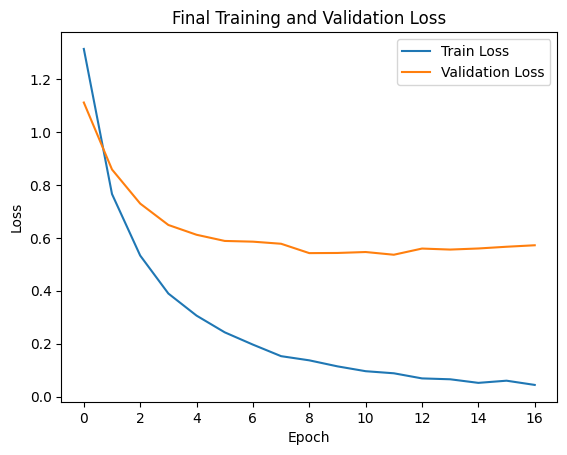

In [11]:
# Retrieve best hyperparameters from the Optuna study
best_params = study.best_params
best_lr = best_params['lr']
best_momentum = best_params['momentum']
best_batch_size = best_params['batch_size']

# Create DataLoaders using the best batch size
train_loader, val_loader = get_data_loaders(best_batch_size)

# Reinitialize the model
mobilenet_v2_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 6 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Define the optimizer and criterion
best_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=best_lr, momentum=best_momentum)
criterion = nn.CrossEntropyLoss()

# Train the model with the best hyperparameters
print("Training MobileNet_v2 with best hyperparameters...")
final_train_losses, final_val_losses = train_model(
    mobilenet_v2_model, train_loader, val_loader, criterion, best_optimizer, device, epochs=20, patience=5
)

# Plot final training and validation loss curves
plt.plot(final_train_losses, label='Train Loss')
plt.plot(final_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training and Validation Loss')
plt.legend()
plt.show()

# After training


MobileNet_v2 Metrics:
Accuracy: 86.36%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.93      0.99      0.96        81
       glass       0.82      0.97      0.89       100
       metal       0.83      0.99      0.90        82
       paper       0.85      0.98      0.91       119
     plastic       0.94      0.64      0.76        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.86       506
   macro avg       0.73      0.76      0.74       506
weighted avg       0.82      0.86      0.84       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


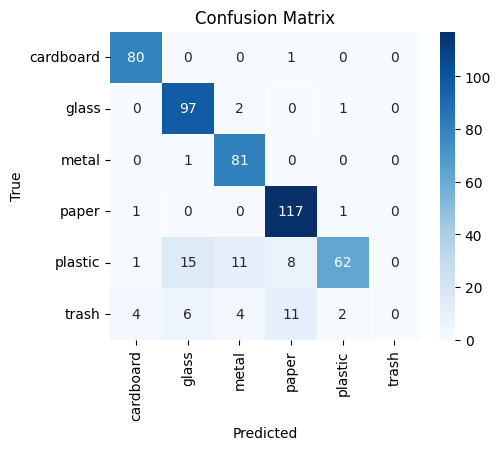

In [12]:
# # Evaluate ResNet-18
# print("ResNet-18 Metrics:")
# resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# # Evaluate EfficientNet_B0
# print("\nEfficientNet_B0 Metrics:")
# efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


In [13]:
# Store results for comparison
# results = {
#     "ResNet-18": {
#         "Before Training": {"Accuracy": resnet18_accuracy_before},
#         "After Training": {"Accuracy": resnet18_accuracy_after},
#     },
#     "MobileNet_v2": {
#         "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
#         "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
#     },
#     "EfficientNet_B0": {
#         "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
#         "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
#     },
# }

results = {
    "MobileNet_v2": {
        "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
        "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
    }
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



MobileNet_v2 Results:
  Before Training Accuracy: 17.59%
  After Training Accuracy: 86.36%


ResNet-18 Misclassifications:


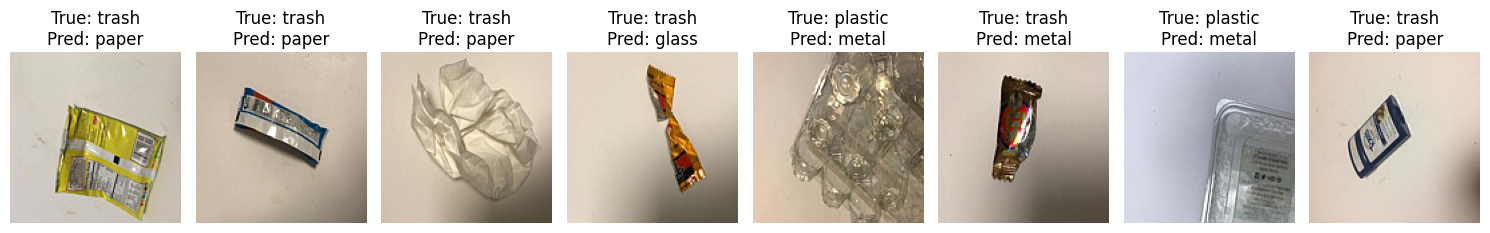

In [14]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(mobilenet_v2_model, test_loader, device, classes, num_images=8)


In [15]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a symbolic link for easier access
!ln -s "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Experimentation_3" /content/Experimentation_3
print("Symbolic link created: /content/Experimentation_3")

# Define the path to the Results folder
folder_path = '/content/Experimentation_3/Results'

# Create the Results folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Define the path for the JSON file for Version 4
json_file_path = os.path.join(folder_path, "model_results_v4.json")

# Save the results as Version 4
try:
    with open(json_file_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Version 4 Results saved to: {json_file_path}")
except NameError:
    print("Error: The 'results' dictionary is not defined. Ensure you have results from your experiments.")


Mounted at /content/drive
Symbolic link created: /content/Experimentation_3
Folder created (or already exists) at: /content/Experimentation_3/Results
Version 4 Results saved to: /content/Experimentation_3/Results/model_results_v4.json
